In [71]:
import os
import warnings

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from IPython.display import clear_output
from sklearn.decomposition import PCA
from scipy import stats

os.chdir("../")

from src import micro

%load_ext autoreload
%autoreload 2

warnings.filterwarnings("ignore")
clear_output()


# 3. Data Preparation (Data Cleaning and Preprocessing)

Given the potential presence of inaccuracies or missing data within our dataset, it is imperative to undertake a comprehensive data preparation process as an initial step. 

Furthermore, uncovering latent patterns concealed within the dataset holds the promise of enhancing the predictive capabilities of our model. Hence, diligent efforts will be made to identify and leverage such patterns. 

## Exploratory Data Analysis (EDA)

<div align="center">
   <img src="../assets/img/Exploratory_data_anaysis.jpg" width="80%">
  </br>
</div>


</br>

**Exploratory Data Analysis (EDA) is the cornerstone of any data science project.** It involves a deep dive into the dataset to uncover its characteristics, identify patterns, and gain valuable insights. Data scientists utilize various techniques, including statistical summaries, visualizations, and data manipulation, to explore trends, anomalies (outliers), and relationships between variables.

**Techniques Employed in EDA**

* **Statistical Summaries:** These provide basic measures of central tendency (mean, median) and spread (standard deviation) for numerical features. Additionally, frequency tables help understand the distribution of categorical variables.
* **Visualizations:** Techniques like scatter plots, histograms, and boxplots allow us to visualize relationships between variables, identify trends, and detect outliers.
* **Data Manipulation:** Data manipulation techniques like sorting, filtering, and grouping help us focus on specific subsets of the data for a more granular analysis.

**Outlier Detection and Handling**

During EDA, we may encounter outliers, which are data points that fall significantly outside the expected range. Techniques like Interquartile Range (IQR) are used to identify them. Values beyond a certain threshold (e.g., 1.5 times the IQR) can be considered outliers. However, it's crucial to investigate potential reasons for outliers before simply removing them. They might be genuine data points and removing them could introduce bias.

**Missing Value Handling**

Another common challenge in EDA is missing data. Depending on the extent and nature of missing values, different techniques can be employed. Here are some common approaches:

* **Deletion:** If missing values are minimal and unlikely to significantly impact analysis, deletion might be an option.
* **Imputation:** This involves filling in missing values with estimates based on other data points. Techniques like mean/median imputation or k-Nearest Neighbors can be used.

Since some of the behaviors are not vivid we need to use different visuals or methods to find these patterns. (At the end we might not even find any!)

At first, Since some of the types that has been chosen by pandas automatically might take the memory too much we will try and change the type of some columns.

In [2]:
# Load data
train_df = micro.read_parquet_file("application_train")
test_df = micro.read_parquet_file("application_test")


In [3]:
# Decrease the size of data
train_df = micro.ChangeType(train_df, "int64", "int32")
train_df = micro.ChangeType(train_df, "float64", "float32")

test_df = micro.ChangeType(test_df, "int64", "int32")
test_df = micro.ChangeType(test_df, "float64", "float32")


### TARGET distribution

First, We see the distribution of our target variable.

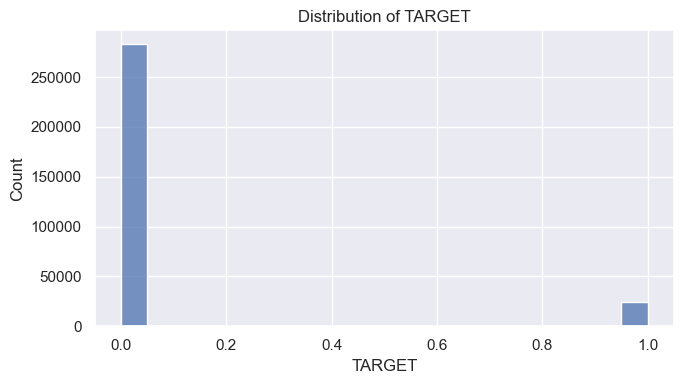

In [4]:
sns.histplot(train_df["TARGET"]).set(title="Distribution of TARGET")
plt.tight_layout()
plt.show()


Based on the chart above we deduct that we are dealing with a very unbalanced dataset, and we need to cover this issue in the modeling section.

## 3.1 Outliers

After dealing with high correlation columns, We could check other variables that could have some information or might be related to the previously analyzed variables.

At first we start by selecting the numerical columns:

In [5]:
numerical_df = micro.select_numerical_variables(train_df)

Numerical columns are: 
 ['CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'ELEVATORS_AVG', 'ENTRANCES_AVG', 'FLOORSMAX_AVG', 'FLOORSMIN_AVG', 'LANDAREA_AVG', 'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG', 'NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAREA_AVG', 'APARTMENTS_MODE', 'BASEMENTAREA_MODE', 'YEARS_BEGINEXPLUATATION_MODE', 'YEA

In [6]:
numerical_df.head(5)

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461,-637,-3648.0,-2120,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16765,-1188,-1186.0,-291,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,67500.0,135000.0,6750.0,135000.0,0.010032,-19046,-225,-4260.0,-2531,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,135000.0,312682.5,29686.5,297000.0,0.008019,-19005,-3039,-9833.0,-2437,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,0,121500.0,513000.0,21865.5,513000.0,0.028663,-19932,-3038,-4311.0,-3458,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


We start by columns which start by `AMT` Keyword:

- `AMT_INCOME_TOTAL`: Income of the client
- `AMT_CREDIT`: Credit amount of the loan
- `AMT_ANNUITY`: Loan annuity
- `AMT_GOODS_PRICE`: For consumer loans it is the price of the goods for which the loan is given

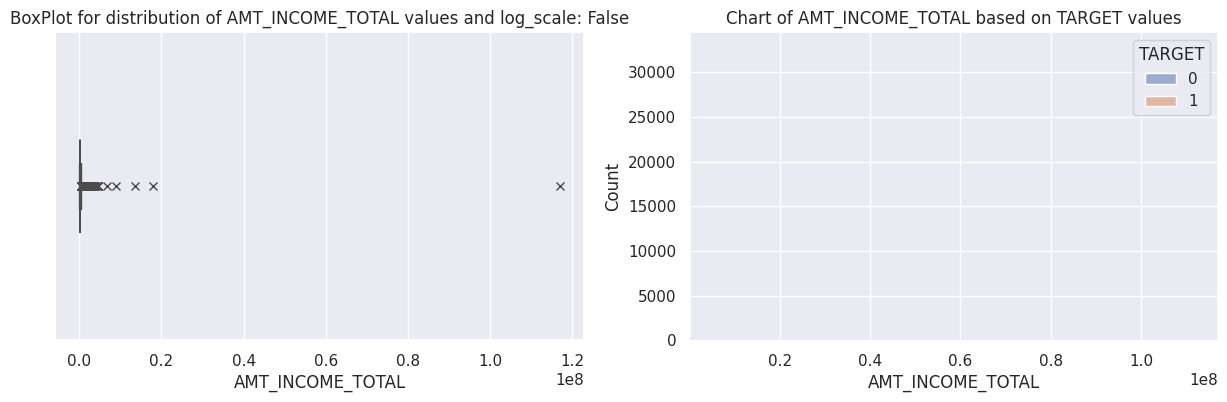

In [ ]:
micro.explore_var_vs_target(train_df, "AMT_INCOME_TOTAL")

It seems that our data has some values that which are extreme. Let's plot the boxplot with log scale.

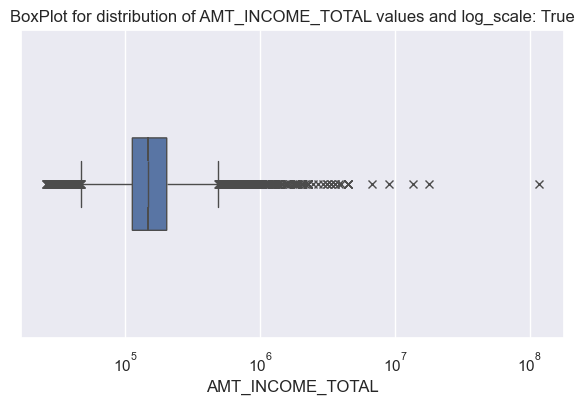

count    3.075110e+05
mean     1.687979e+05
std      2.371231e+05
min      2.565000e+04
25%      1.125000e+05
50%      1.471500e+05
75%      2.025000e+05
max      1.170000e+08
Name: AMT_INCOME_TOTAL, dtype: float64


In [7]:
micro.plot_box_var(train_df, "AMT_INCOME_TOTAL", log_scale=True)
print(train_df["AMT_INCOME_TOTAL"].describe())


Let's see if we can have a distribution about the outliers data and see how we can handle them, First we try and use the `log` transform to see if the distribution of data is close to normal distribution.

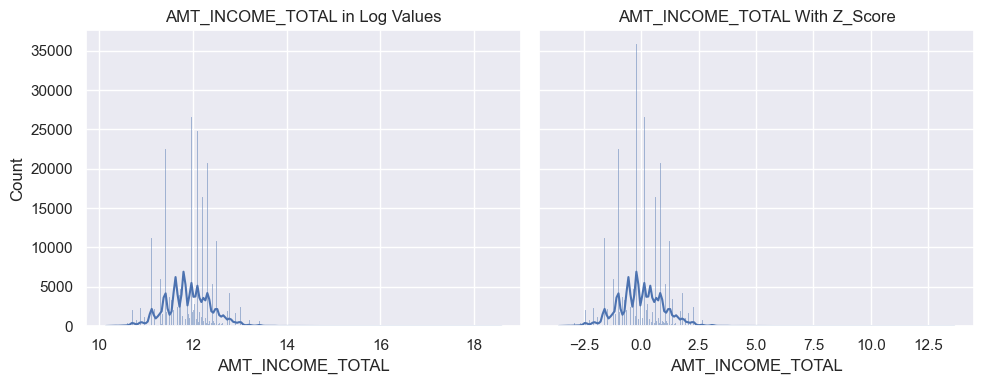

In [11]:
fig, ax = plt.subplots(ncols=2, nrows=1, sharey=True, figsize=(10, 4))
sns.histplot(np.log(train_df["AMT_INCOME_TOTAL"]), kde=True, ax=ax[0]).set(
    title="AMT_INCOME_TOTAL in Log Values"
)


sns.histplot(
    stats.zscore(np.log(train_df["AMT_INCOME_TOTAL"])),
    kde=True,
    ax=ax[1],
).set(title="AMT_INCOME_TOTAL With Z_Score")
fig.tight_layout()
plt.show()


We could use Z-Score outlier detection and replace the outlier values with `mean + 3*sigma` values.

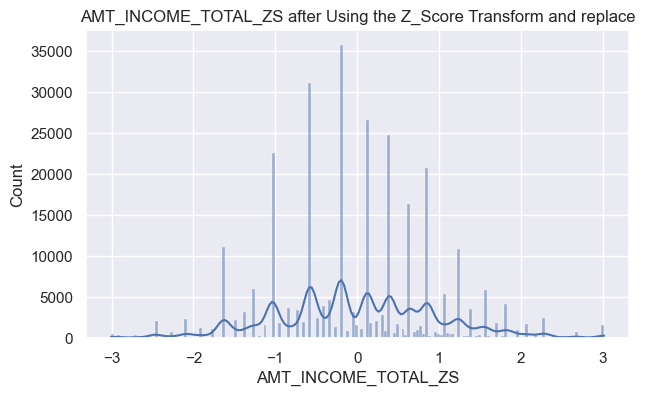

In [12]:
train_df, standard_scaler = train_df.pipe(
    micro.compute_transform_zscore, col_name="AMT_INCOME_TOTAL"
)


test_df["AMT_INCOME_TOTAL_ZS"] = test_df.pipe(
    micro.transform_test_data_zscore,
    col_name="AMT_INCOME_TOTAL",
    apply_log=True,
    std_scaler=standard_scaler,
)

# train_df = train_df.drop(columns=["AMT_INCOME_TOTAL", "AMT_INCOME_TOTAL_LOG"])
# test_df = test_df.drop(columns=["AMT_INCOME_TOTAL"])

sns.histplot(
    train_df["AMT_INCOME_TOTAL_ZS"],
    kde=True,
).set(title="AMT_INCOME_TOTAL_ZS after Using the Z_Score Transform and replace")

plt.show()


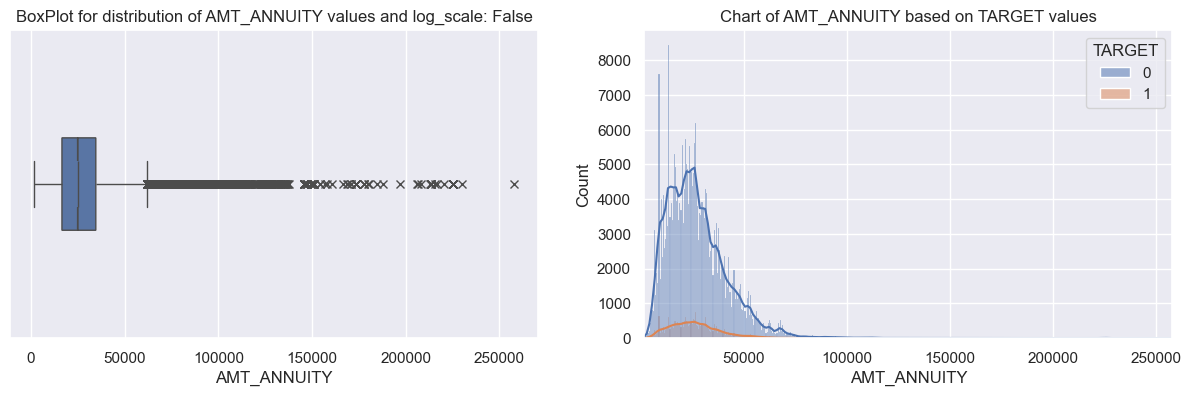

In [13]:
micro.explore_var_vs_target(train_df, "AMT_ANNUITY")

In the form of log-scale and using z-transform, `AMT_ANNUITY` seems to follow a normal distribution with not so much outliers. So we change the distribution to the z-score of log-transformed.

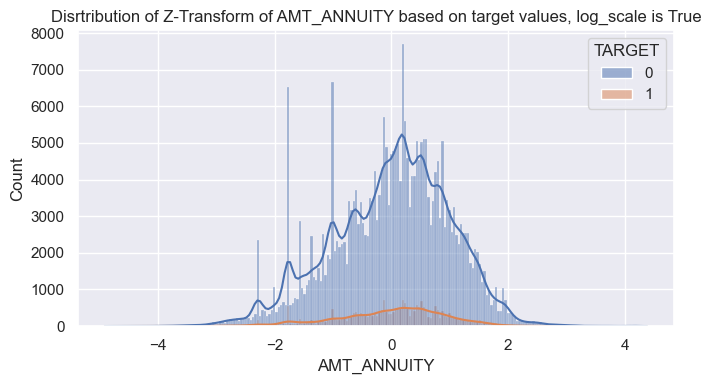

In [14]:
# Plot the log-scaled histograms
train_df.pipe(micro.plot_var_zscore, col_name="AMT_ANNUITY", log_scale=True)

# Apply the zscore transformation
train_df, standard_scaler = train_df.pipe(
    micro.compute_transform_zscore, col_name="AMT_ANNUITY"
)

test_df["AMT_ANNUITY_ZS"] = test_df.pipe(
    micro.transform_test_data_zscore,
    col_name="AMT_ANNUITY",
    apply_log=True,
    std_scaler=standard_scaler,
)

train_df = train_df.drop(columns=["AMT_ANNUITY", "AMT_ANNUITY_LOG"])
test_df = test_df.drop(columns=["AMT_ANNUITY"])


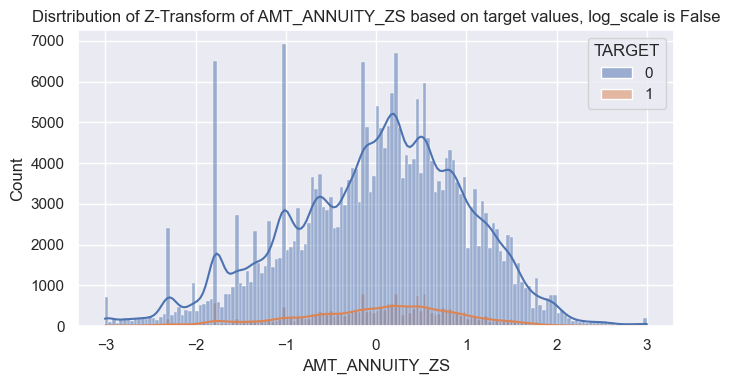

In [15]:
train_df.pipe(micro.plot_var_zscore, col_name="AMT_ANNUITY_ZS", log_scale=False)

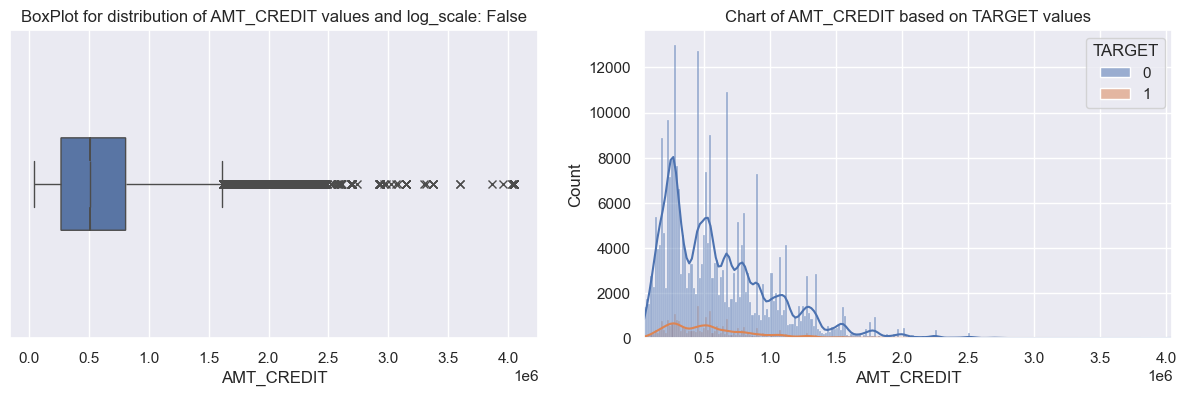

In [16]:
train_df.pipe(micro.explore_var_vs_target, col_name="AMT_CREDIT")

On the log scale the data seems to be normaly distributed and doesn't have much outlier data in it, so we leave it to be.

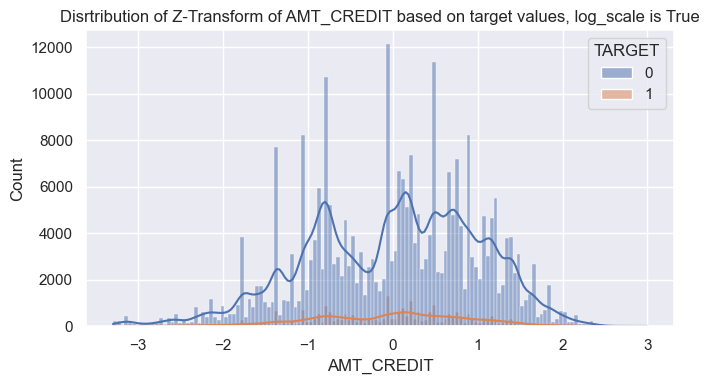

In [17]:
micro.plot_var_zscore(train_df, "AMT_CREDIT", log_scale=True)

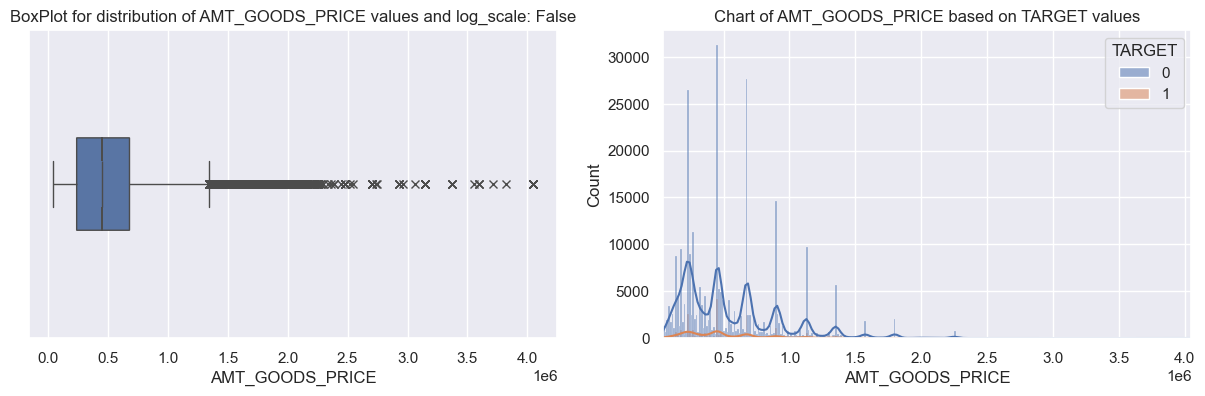

In [18]:
train_df.pipe(micro.explore_var_vs_target, col_name="AMT_GOODS_PRICE")

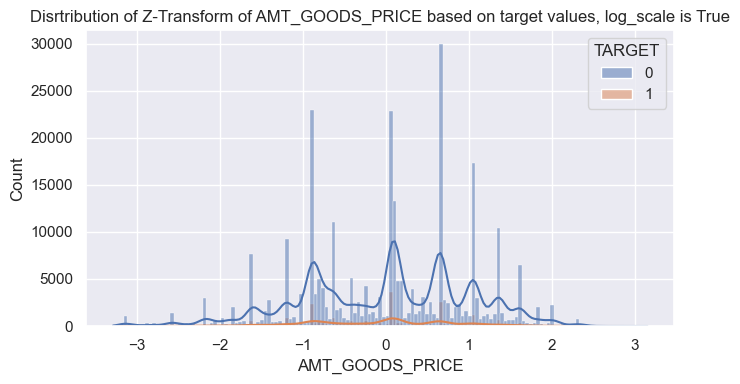

In [19]:
micro.plot_var_zscore(train_df, "AMT_GOODS_PRICE", log_scale=True)

It seems that if we use the z-score of the log-transformed data for `AMT_GOODS_PRICE` we would have a better distribution of data to deal with.

For Both columns of `AMT_GOODS_PRICE` and `AMT_CREDIT` we don't change them for now and deal with them later in the correlation section.

Let's Explore some other columns which contain other information about the data.

- `DAYS_BIRTH`: Client's age in days at the time of application
- `DAYS_EMPLOYED`: How many days before the application the person started current employment
- `DAYS_REGISTRATION`: How many days before the application did client change his registration
- `DAYS_ID_PUBLISH`: How many days before the application did client change the identity document with which he applied for the loan

 We start by column `DAYS_EMPLOYED`:

- `DAYS_EMPLOYED`: How many days before the application the person started current employment.

Let's first plot the distribution of data:

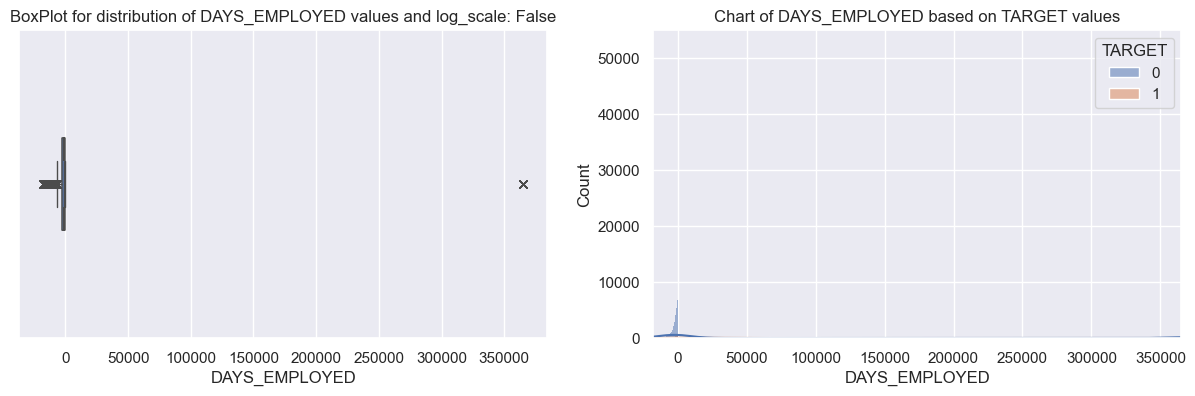

In [20]:
train_df.pipe(micro.explore_var_vs_target, col_name="DAYS_EMPLOYED")

It seems that there are some high values which are so much apart from the most of data:

In [21]:
train_df["DAYS_EMPLOYED"].describe()

count    307511.000000
mean      63815.045904
std      141275.766519
min      -17912.000000
25%       -2760.000000
50%       -1213.000000
75%        -289.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

There is a Very high value of 365243 Days (By definition of the varibale BEFORE the application). Based on the values we see in the column the most of the values seem to be negative which based on the definition it makes sense.

So we need to see how many the positive values we have since they could be a wrong number or NA value which were replace mistakenly.

In [22]:
employ_condition = train_df["DAYS_EMPLOYED"] > 0
print(train_df.loc[employ_condition, "DAYS_EMPLOYED"])

print(
    "\nStatistics of Values more than zero: \n",
    train_df.loc[employ_condition, "DAYS_EMPLOYED"].describe(),
)


8         365243
11        365243
23        365243
38        365243
43        365243
           ...  
307469    365243
307483    365243
307487    365243
307505    365243
307507    365243
Name: DAYS_EMPLOYED, Length: 55374, dtype: int64

Statistics of Values more than zero: 
 count     55374.0
mean     365243.0
std           0.0
min      365243.0
25%      365243.0
50%      365243.0
75%      365243.0
max      365243.0
Name: DAYS_EMPLOYED, dtype: float64


We see that all of the values more than zero (55374 Counts) are 365243, So we can replace them all with NA values so later we decide for a logical value to fill them.

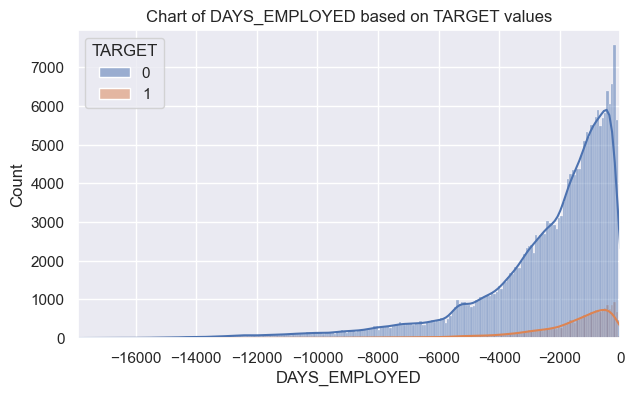

In [23]:
row_condition = train_df["DAYS_EMPLOYED"] > 0
train_df.loc[row_condition, "DAYS_EMPLOYED"] = np.nan

row_condition = test_df["DAYS_EMPLOYED"] > 0
test_df.loc[row_condition, "DAYS_EMPLOYED"] = np.nan


micro.plot_hist_var_target(train_df, "DAYS_EMPLOYED")


The values registered for `DAYS_BIRTH` seem to be valid since charts doesn't show any anomalies and also the values differ between 20 to 68 years which seems reasonable.

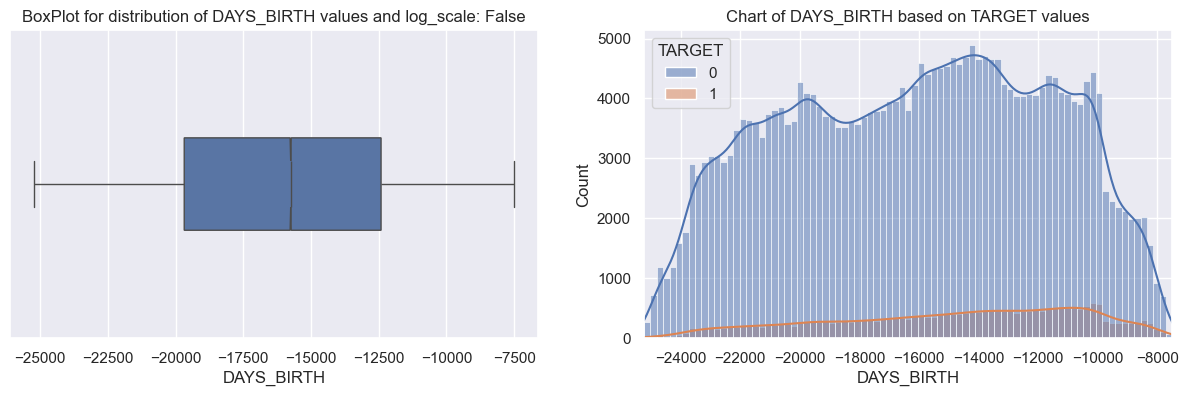

In [24]:
train_df.pipe(micro.explore_var_vs_target, col_name="DAYS_BIRTH")

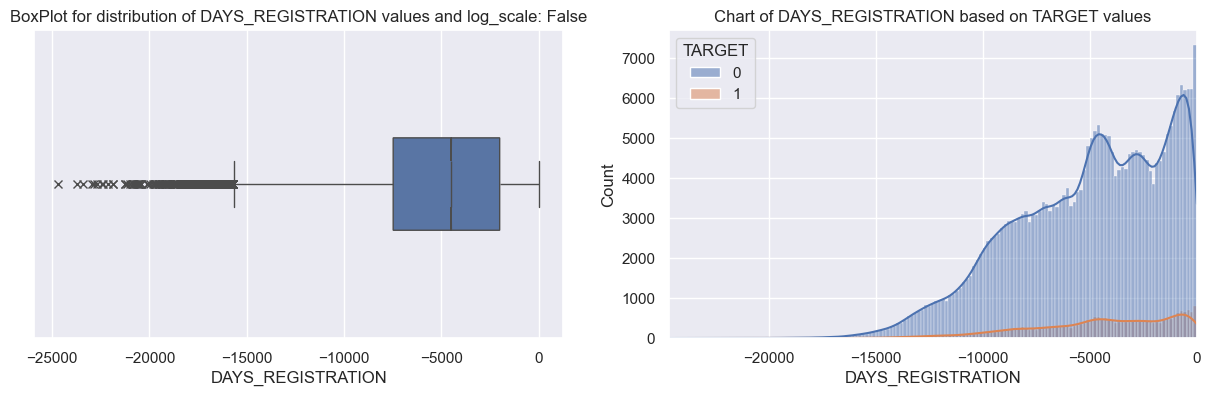

In [25]:
train_df.pipe(micro.explore_var_vs_target, col_name="DAYS_REGISTRATION")

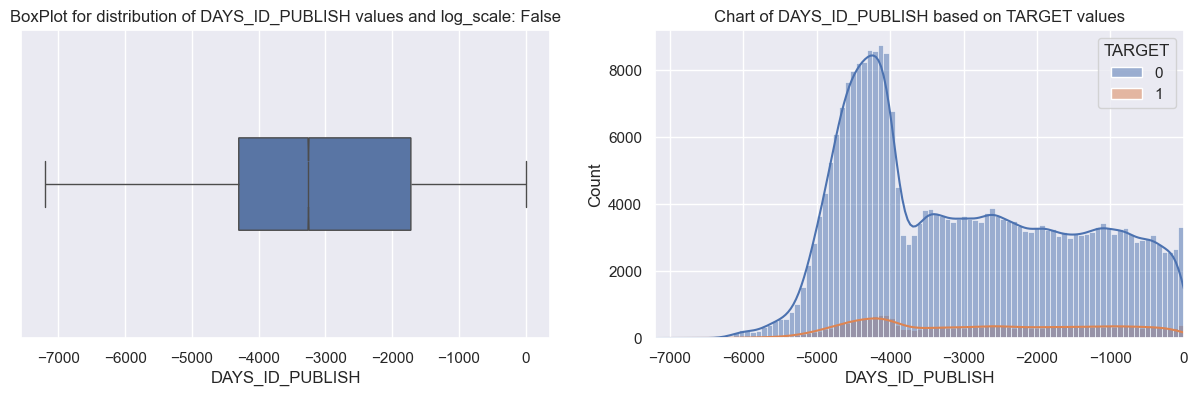

In [26]:
train_df.pipe(micro.explore_var_vs_target, col_name="DAYS_ID_PUBLISH")

- `AMT_REQ_CREDIT_BUREAU_HOUR`: Number of enquiries to Credit Bureau about the client one hour before application
- `AMT_REQ_CREDIT_BUREAU_DAY`: Number of enquiries to Credit Bureau about the client one day before application (excluding one hour before application)
- `AMT_REQ_CREDIT_BUREAU_WEEK`: Number of enquiries to Credit Bureau about the client one week before application (excluding one day before application)
- `AMT_REQ_CREDIT_BUREAU_MON`: Number of enquiries to Credit Bureau about the client one month before application (excluding one week before application)
- `AMT_REQ_CREDIT_BUREAU_QRT`: Number of enquiries to Credit Bureau about the client 3 month before application (excluding one month before application)
- `AMT_REQ_CREDIT_BUREAU_YEAR`: Number of enquiries to Credit Bureau about the client one day year (excluding last 3 months before application)

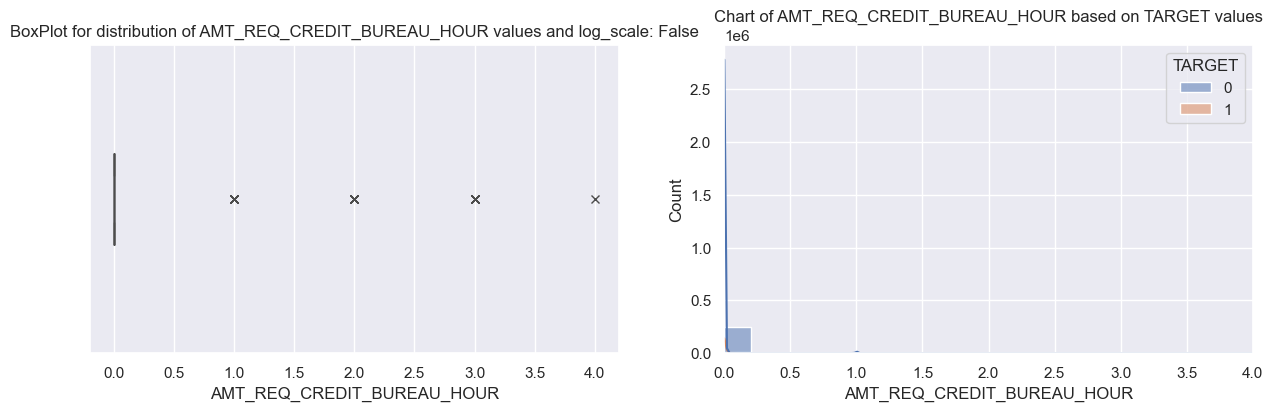

In [27]:
train_df.pipe(micro.explore_var_vs_target, col_name="AMT_REQ_CREDIT_BUREAU_HOUR")

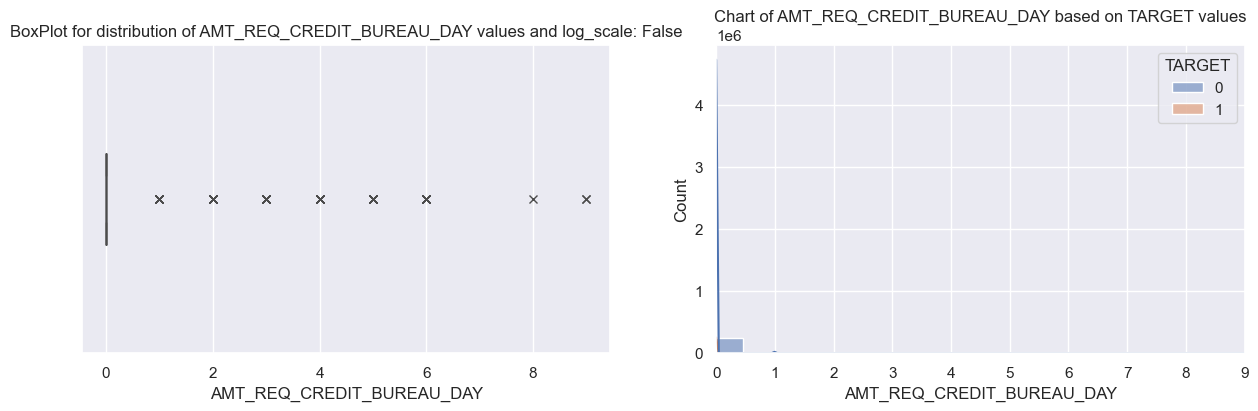

In [28]:
train_df.pipe(micro.explore_var_vs_target, col_name="AMT_REQ_CREDIT_BUREAU_DAY")

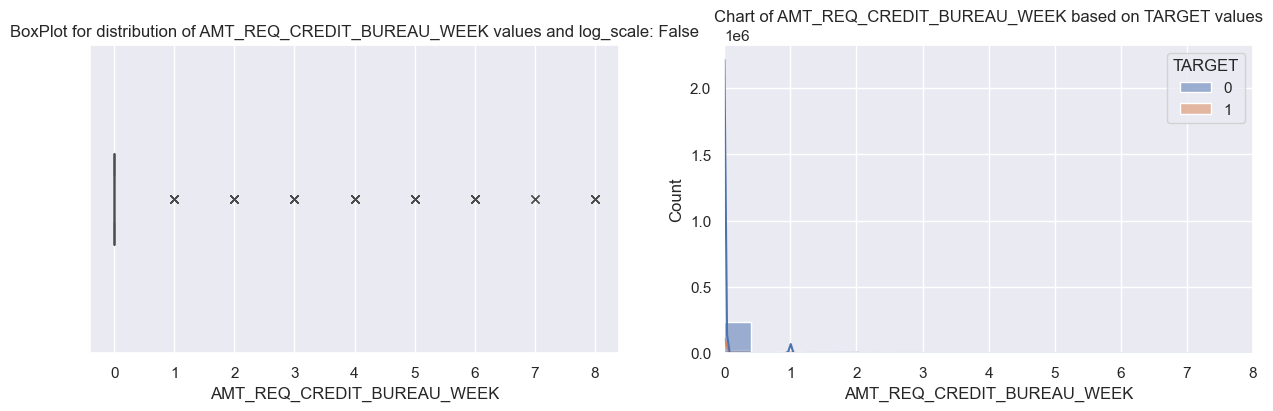

In [29]:
train_df.pipe(micro.explore_var_vs_target, col_name="AMT_REQ_CREDIT_BUREAU_WEEK")

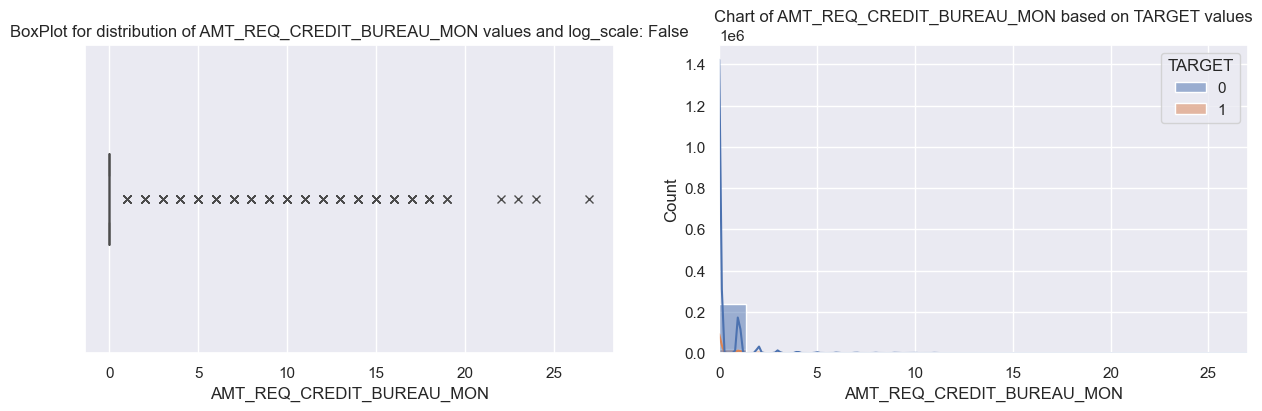

In [30]:
train_df.pipe(micro.explore_var_vs_target, col_name="AMT_REQ_CREDIT_BUREAU_MON")

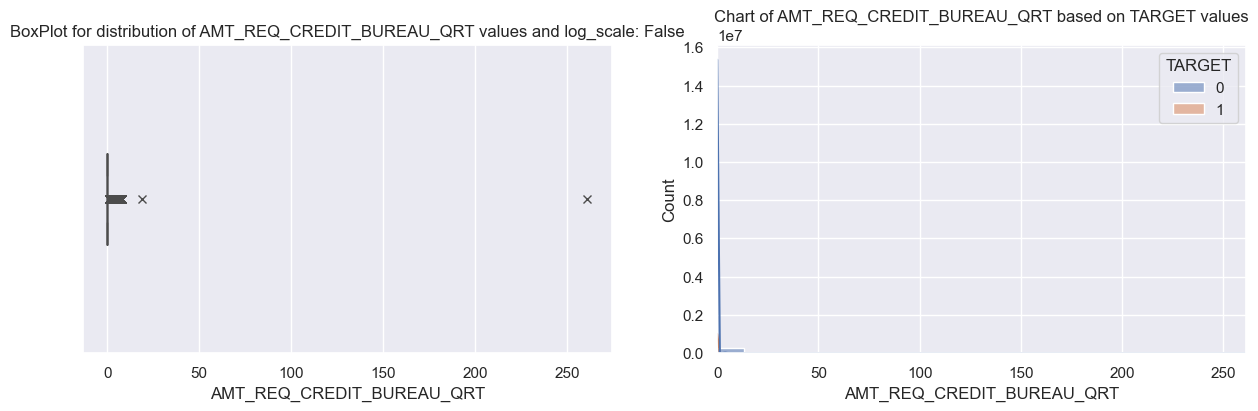

In [31]:
train_df.pipe(micro.explore_var_vs_target, col_name="AMT_REQ_CREDIT_BUREAU_QRT")

We see some outlier data in this column let's explore it more:

In [32]:
train_df["AMT_REQ_CREDIT_BUREAU_QRT"].describe()

count    265992.000000
mean          0.265474
std           0.794056
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max         261.000000
Name: AMT_REQ_CREDIT_BUREAU_QRT, dtype: float64

Maximum value of 261 requests seems a bit strange and there is only one occurence of this so we could just replace the value with median of the column which is 0 based on description above.

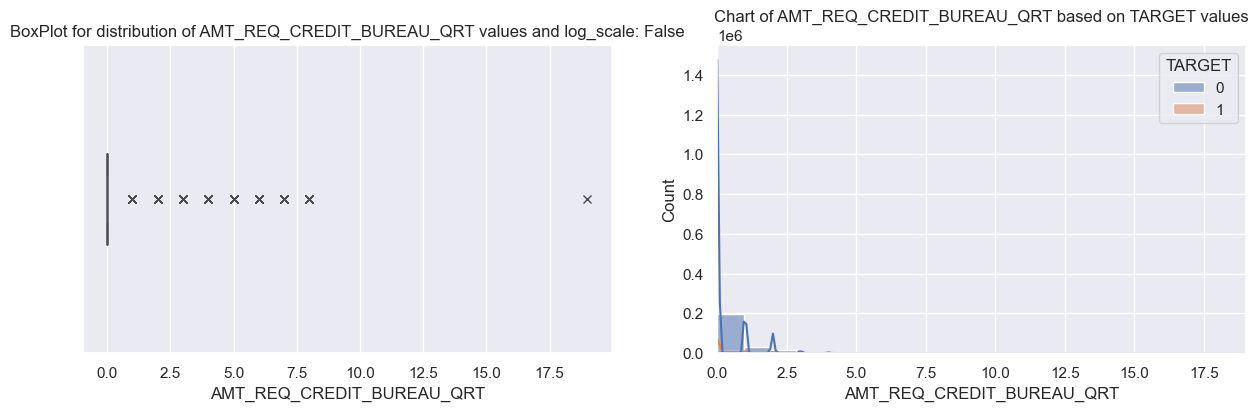

In [33]:
train_df.loc[
    (train_df["AMT_REQ_CREDIT_BUREAU_QRT"] == 261), "AMT_REQ_CREDIT_BUREAU_QRT"
] = 0

train_df.pipe(micro.explore_var_vs_target, col_name="AMT_REQ_CREDIT_BUREAU_QRT")


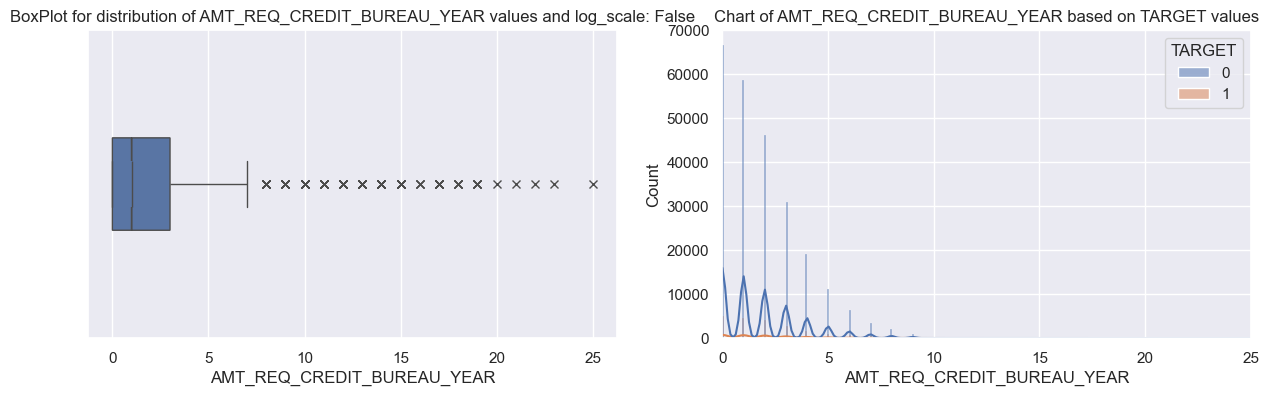

In [34]:
train_df.pipe(micro.explore_var_vs_target, col_name="AMT_REQ_CREDIT_BUREAU_YEAR")

## 3.2 Missing Values

In ordert o deal with missing values we take severla steps to identify and solve the issues related to them.

First, we want to see how many of our columns have more than acceptable missin values.

In [35]:
na_series = train_df.isna().sum()
na_series = na_series[(na_series != 0)]
na_cols = na_series.index

# See the Null values from low to high
display(na_series.sort_values(ascending=True))

print("Number of Null columns: {}".format(len(na_series)))


DAYS_LAST_PHONE_CHANGE           1
CNT_FAM_MEMBERS                  2
AMT_ANNUITY_ZS                  12
AMT_GOODS_PRICE                278
EXT_SOURCE_2                   660
                             ...  
NONLIVINGAPARTMENTS_AVG     213514
NONLIVINGAPARTMENTS_MODE    213514
COMMONAREA_MEDI             214865
COMMONAREA_MODE             214865
COMMONAREA_AVG              214865
Length: 68, dtype: int64

Number of Null columns: 68


We have 66 Variables that have missing values. So we need to take care of them before doing any further analysis.


In [36]:
# Create a mask to see Which columns has less than 30% NA Values
nonan_cols = (train_df.isna().sum(axis=0) / train_df.shape[0] * 100) <= 30
display(train_df.loc[:, nonan_cols])

# Select those columns which have more than 30% NA value
nan_cols = nonan_cols[(nonan_cols == False)].index.to_list()
print(
    f"Number of columns with more than acceptable missing values are {len(nan_cols)} and the names of these columns are: {nan_cols}"
)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,AMT_INCOME_TOTAL_LOG,AMT_INCOME_TOTAL_ZS,AMT_ANNUITY_ZS
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,351000.0,...,0,0.0,0.0,0.0,0.0,0.0,1.0,12.218495,0.641563,0.085810
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,1129500.0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,12.506177,1.236333,0.762647
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,135000.0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,11.119883,-1.629769,-2.298342
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,297000.0,...,0,NaN,NaN,NaN,NaN,NaN,NaN,11.813030,-0.196718,0.423726
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,513000.0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,11.707670,-0.414546,-0.138243
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0,Cash loans,M,N,N,0,157500.0,254700.0,225000.0,...,0,NaN,NaN,NaN,NaN,NaN,NaN,11.967181,0.121982,0.286994
307507,456252,0,Cash loans,F,N,Y,0,72000.0,269550.0,225000.0,...,0,NaN,NaN,NaN,NaN,NaN,NaN,11.184421,-1.496339,-1.240704
307508,456253,0,Cash loans,F,N,Y,0,153000.0,677664.0,585000.0,...,0,1.0,0.0,0.0,1.0,0.0,1.0,11.938193,0.062051,0.441745
307509,456254,1,Cash loans,F,N,Y,0,171000.0,370107.0,319500.0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,12.049419,0.292005,-0.283393


Number of columns with more than acceptable missing values are 50 and the names of these columns are: ['OWN_CAR_AGE', 'OCCUPATION_TYPE', 'EXT_SOURCE_1', 'APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'ELEVATORS_AVG', 'ENTRANCES_AVG', 'FLOORSMAX_AVG', 'FLOORSMIN_AVG', 'LANDAREA_AVG', 'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG', 'NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAREA_AVG', 'APARTMENTS_MODE', 'BASEMENTAREA_MODE', 'YEARS_BEGINEXPLUATATION_MODE', 'YEARS_BUILD_MODE', 'COMMONAREA_MODE', 'ELEVATORS_MODE', 'ENTRANCES_MODE', 'FLOORSMAX_MODE', 'FLOORSMIN_MODE', 'LANDAREA_MODE', 'LIVINGAPARTMENTS_MODE', 'LIVINGAREA_MODE', 'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAREA_MODE', 'APARTMENTS_MEDI', 'BASEMENTAREA_MEDI', 'YEARS_BEGINEXPLUATATION_MEDI', 'YEARS_BUILD_MEDI', 'COMMONAREA_MEDI', 'ELEVATORS_MEDI', 'ENTRANCES_MEDI', 'FLOORSMAX_MEDI', 'FLOORSMIN_MEDI', 'LANDAREA_MEDI', 'LIVINGAPARTMENTS_MEDI', 'LIVINGAREA_MEDI', 'NONLIVINGAPARTMENTS_MEDI', '

We can see that we have more than 50 columns out of 121 which has more than 30% missing values.  But we maybe able to fill them if start to see some pattern in the data or find some other information that could lead us to fill in the values.

At first look, we can see that many of the missing clumns name are related to the porperties of the applicant's house. These Columns name include:

['APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'ELEVATORS_AVG', 'ENTRANCES_AVG', 'FLOORSMAX_AVG', 'FLOORSMIN_AVG', 'LANDAREA_AVG', 'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG', 'NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAREA_AVG', 'APARTMENTS_MODE', 'BASEMENTAREA_MODE', 'YEARS_BEGINEXPLUATATION_MODE', 'YEARS_BUILD_MODE', 'COMMONAREA_MODE', 'ELEVATORS_MODE', 'ENTRANCES_MODE', 'FLOORSMAX_MODE', 'FLOORSMIN_MODE', 'LANDAREA_MODE', 'LIVINGAPARTMENTS_MODE', 'LIVINGAREA_MODE', 'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAREA_MODE', 'APARTMENTS_MEDI', 'BASEMENTAREA_MEDI', 'YEARS_BEGINEXPLUATATION_MEDI', 'YEARS_BUILD_MEDI', 'COMMONAREA_MEDI', 'ELEVATORS_MEDI', 'ENTRANCES_MEDI', 'FLOORSMAX_MEDI', 'FLOORSMIN_MEDI', 'LANDAREA_MEDI', 'LIVINGAPARTMENTS_MEDI', 'LIVINGAREA_MEDI', 'NONLIVINGAPARTMENTS_MEDI', 'NONLIVINGAREA_MEDI', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'TOTALAREA_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE']

The Median, Average of Mode of the applicant's house has many missing values. we might be able to deal with these values later based on other provided details. First, we start by __Exploratory Data Analysis__ to gain more insights about the data we are trying to analyze.

In [37]:
# Let's find out the names wothoud the AVG or MEDI tags
print(sorted(list(set([x.split("_")[0] for x in nan_cols]))))


['APARTMENTS', 'BASEMENTAREA', 'COMMONAREA', 'ELEVATORS', 'EMERGENCYSTATE', 'ENTRANCES', 'EXT', 'FLOORSMAX', 'FLOORSMIN', 'FONDKAPREMONT', 'HOUSETYPE', 'LANDAREA', 'LIVINGAPARTMENTS', 'LIVINGAREA', 'NONLIVINGAPARTMENTS', 'NONLIVINGAREA', 'OCCUPATION', 'OWN', 'TOTALAREA', 'WALLSMATERIAL', 'YEARS']


These are the explanations for each of the items listed above:

- `APARTMENTS_AVG`: Normalized information about building where the client lives, What is average (_AVG suffix), modus (...
- `BASEMENTAREA_AVG`: Normalized information about building where the client lives, What is average (_AVG suffix), modus (...
- `COMMONAREA_AVG`: Normalized information about building where the client lives, What is average (_AVG suffix), modus (...
- `ELEVATORS_AVG`: Normalized information about building where the client lives, What is average (_AVG suffix), modus (...
- `ENTRANCES_AVG`: Normalized information about building where the client lives, What is average (_AVG suffix), modus (...
- `FLOORSMAX_AVG`: Normalized information about building where the client lives, What is average (_AVG suffix), modus (...
- `FLOORSMIN_AVG`: Normalized information about building where the client lives, What is average (_AVG suffix), modus (...
- `LANDAREA_AVG`: Normalized information about building where the client lives, What is average (_AVG suffix), modus (...
- `LIVINGAPARTMENTS_AVG`: Normalized information about building where the client lives, What is average (_AVG suffix), modus (...
- `LIVINGAREA_AVG`: Normalized information about building where the client lives, What is average (_AVG suffix), modus (...
- `NONLIVINGAPARTMENTS_AVG`: Normalized information about building where the client lives, What is average (_AVG suffix), modus (...
- `NONLIVINGAREA_AVG`: Normalized information about building where the client lives, What is average (_AVG suffix), modus (...
- `YEARS_BEGINEXPLUATATION_AVG`: Normalized information about building where the client lives, What is average (_AVG suffix), modus (...
- `YEARS_BUILD_AVG`: Normalized information about building where the client lives, What is average (_AVG suffix), modus (...
- `OWN_CAR_AGE`: Age of client's car
- `OCCUPATION_TYPE`: What kind of occupation does the client have


By Seperating the columns related to house, we could derive a Score-Based system In order to solve the many Na values in the housse descriptions. We observe that all of the Points for the selected house properties are between 0 and 1, so we could derive a Score-based systme just by adding the numbers for each applicant. 
In this way we get a better Score for applicant with better condition in their house and 0 for the aplicant which hasn't provided any house related information.

In [38]:
house_cols = [
    "APARTMENTS_AVG",
    "BASEMENTAREA_AVG",
    "YEARS_BEGINEXPLUATATION_AVG",
    "YEARS_BUILD_AVG",
    "COMMONAREA_AVG",
    "ELEVATORS_AVG",
    "ENTRANCES_AVG",
    "FLOORSMAX_AVG",
    "FLOORSMIN_AVG",
    "LANDAREA_AVG",
    "LIVINGAPARTMENTS_AVG",
    "LIVINGAREA_AVG",
    "NONLIVINGAPARTMENTS_AVG",
    "NONLIVINGAREA_AVG",
    "APARTMENTS_MODE",
    "BASEMENTAREA_MODE",
    "YEARS_BEGINEXPLUATATION_MODE",
    "YEARS_BUILD_MODE",
    "COMMONAREA_MODE",
    "ELEVATORS_MODE",
    "ENTRANCES_MODE",
    "FLOORSMAX_MODE",
    "FLOORSMIN_MODE",
    "LANDAREA_MODE",
    "LIVINGAPARTMENTS_MODE",
    "LIVINGAREA_MODE",
    "NONLIVINGAPARTMENTS_MODE",
    "NONLIVINGAREA_MODE",
    "TOTALAREA_MODE",
    "APARTMENTS_MEDI",
    "BASEMENTAREA_MEDI",
    "YEARS_BEGINEXPLUATATION_MEDI",
    "YEARS_BUILD_MEDI",
    "COMMONAREA_MEDI",
    "ELEVATORS_MEDI",
    "ENTRANCES_MEDI",
    "FLOORSMAX_MEDI",
    "FLOORSMIN_MEDI",
    "LANDAREA_MEDI",
    "LIVINGAPARTMENTS_MEDI",
    "LIVINGAREA_MEDI",
    "NONLIVINGAPARTMENTS_MEDI",
    "NONLIVINGAREA_MEDI",
]
# Derive the Score for the house
train_df.loc[:, "HOUSE_SCORE"] = train_df.loc[:, house_cols].sum(axis=1)
test_df.loc[:, "HOUSE_SCORE"] = test_df.loc[:, house_cols].sum(axis=1)

train_df = train_df.drop(columns=house_cols)
test_df = test_df.drop(columns=house_cols)


By analyzing the Car related columns we find out that the Na values which are present in "OWN_CAR_AGE" are 99.998% related to those who deosn't have a car. So we can try and fill the empty cells with a value that could describe not having a car or it could seperate the people who has a car from who doesn't.

Maybe the -1 value could be a good start.

In [39]:
tmp_df = train_df[["FLAG_OWN_CAR", "OWN_CAR_AGE"]]
car_na_df = tmp_df[(tmp_df["OWN_CAR_AGE"].isna())]
print(car_na_df["FLAG_OWN_CAR"].describe())

n_values = car_na_df[(car_na_df["FLAG_OWN_CAR"] == "N")]
n_percentage_value = len(n_values) / len(car_na_df) * 100
print(
    "percent of N values related to NA 'OWN_CAR_AGE' values: {:.3f}%".format(
        n_percentage_value
    )
)


count     202929
unique         2
top            N
freq      202924
Name: FLAG_OWN_CAR, dtype: object
percent of N values related to NA 'OWN_CAR_AGE' values: 99.998%


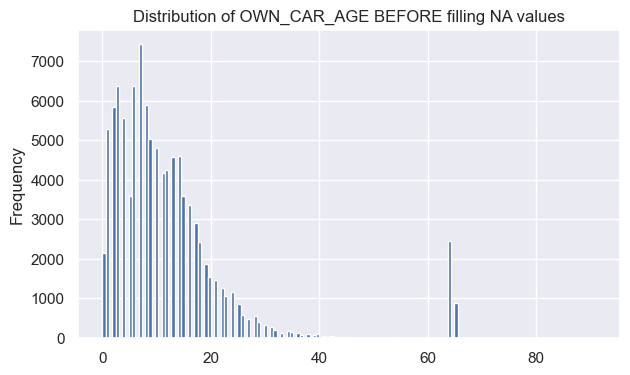

In [40]:
micro.plot_car_histogram(train_df, "BEFORE")

In [41]:
(train_df["OWN_CAR_AGE"]).isna().sum()

202929

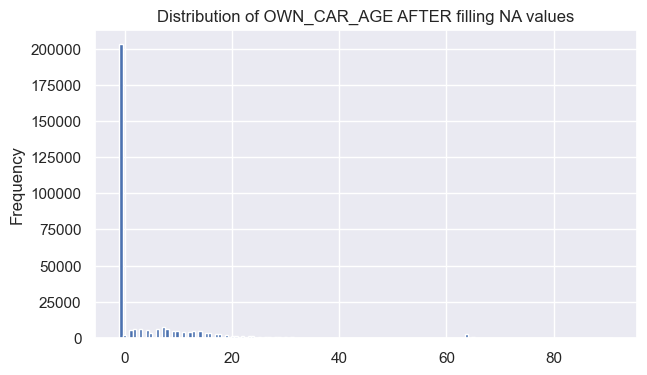

In [42]:
train_df["OWN_CAR_AGE"] = train_df["OWN_CAR_AGE"].fillna(-1)
test_df["OWN_CAR_AGE"] = test_df["OWN_CAR_AGE"].fillna(-1)
micro.plot_car_histogram(train_df, "AFTER")


Though it seems that we have altered the Original distribution of the OWN_CAR_AGE, but we just added a distinct value which could identify that we don't have a car and the distribution of the rest of the data is unchanged.

let's check again to see about the NA values of the columns.

In [43]:
high_na_cols = (train_df.isna().sum(axis=0) / train_df.shape[0] * 100) >= 30
display(train_df.loc[:, high_na_cols])


,OCCUPATION_TYPE,EXT_SOURCE_1,FONDKAPREMONT_MODE,HOUSETYPE_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE
0,Laborers,0.083037,reg oper account,block of flats,"Stone, brick",No
1,Core staff,0.311267,reg oper account,block of flats,Block,No
2,Laborers,NaN,None,None,None,None
3,Laborers,NaN,None,None,None,None
4,Core staff,NaN,None,None,None,None
...,...,...,...,...,...,...
307506,Sales staff,0.145570,reg oper account,block of flats,"Stone, brick",No
307507,None,NaN,reg oper account,block of flats,"Stone, brick",No
307508,Managers,0.744026,reg oper account,block of flats,Panel,No
307509,Laborers,NaN,None,block of flats,"Stone, brick",No


We were able to decrease the number high NA columns to 6. Now we need to figure out a sense between the columns to see if there is a way to find the missing values.
We start by `OCCUPATION_TYPE` column.

In [44]:
train_df[(train_df["OCCUPATION_TYPE"].isna())]["NAME_INCOME_TYPE"].value_counts()

NAME_INCOME_TYPE
Pensioner               55357
Working                 24920
Commercial associate    12297
State servant            3787
Unemployed                 22
Student                     5
Businessman                 2
Maternity leave             1
Name: count, dtype: int64

We could mark the "Pensioners" and "Unemplyed" with value of "No occupation".

In [45]:
occupation_list = ["Unemployed", "Pensioner"]

for occup in occupation_list:
    replace_condition = (train_df["OCCUPATION_TYPE"].isna()) & (
        train_df["NAME_INCOME_TYPE"] == occup
    )

    train_df.loc[replace_condition, "OCCUPATION_TYPE"] = "No occupation"


In [46]:
train_df[(train_df["OCCUPATION_TYPE"].isna())]["NAME_INCOME_TYPE"].value_counts()

NAME_INCOME_TYPE
Working                 24920
Commercial associate    12297
State servant            3787
Student                     5
Businessman                 2
Maternity leave             1
Name: count, dtype: int64

In [47]:
occupation_list = [
    "Commercial associate",
    "Working",
    "State servant",
    "Student",
    "Businessman",
    "Maternity leave",
]
for occup in occupation_list:
    train_df, test_df = micro.replace_occupation_nan(train_df, test_df, occup)


In [48]:
train_df = train_df.pipe(micro.clean_organization_col)
test_df = test_df.pipe(micro.clean_organization_col)


Also we shoudn't forget columns that have low NA values, they still need to be taken care of.

In [52]:
micro.find_low_na_cols(train_df, 30)


AMT_GOODS_PRICE                0.090403
NAME_TYPE_SUITE                0.420148
DAYS_EMPLOYED                 18.007161
CNT_FAM_MEMBERS                0.000650
EXT_SOURCE_2                   0.214626
EXT_SOURCE_3                  19.825307
OBS_30_CNT_SOCIAL_CIRCLE       0.332021
DEF_30_CNT_SOCIAL_CIRCLE       0.332021
OBS_60_CNT_SOCIAL_CIRCLE       0.332021
DEF_60_CNT_SOCIAL_CIRCLE       0.332021
DAYS_LAST_PHONE_CHANGE         0.000325
AMT_REQ_CREDIT_BUREAU_HOUR    13.501631
AMT_REQ_CREDIT_BUREAU_DAY     13.501631
AMT_REQ_CREDIT_BUREAU_WEEK    13.501631
AMT_REQ_CREDIT_BUREAU_MON     13.501631
AMT_REQ_CREDIT_BUREAU_QRT     13.501631
AMT_REQ_CREDIT_BUREAU_YEAR    13.501631
AMT_ANNUITY_ZS                 0.003902
dtype: float64


We can see that many of the NA columns has less than 1% NA values in them so they can be dropped. but the columns ['AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR', 'EXT_SOURCE_19'] has a relatively high NA values. We also should find a way to take care of these values.

For now we don't drop them, We might be able to recover some data using EDA and finding the relationship between columns.

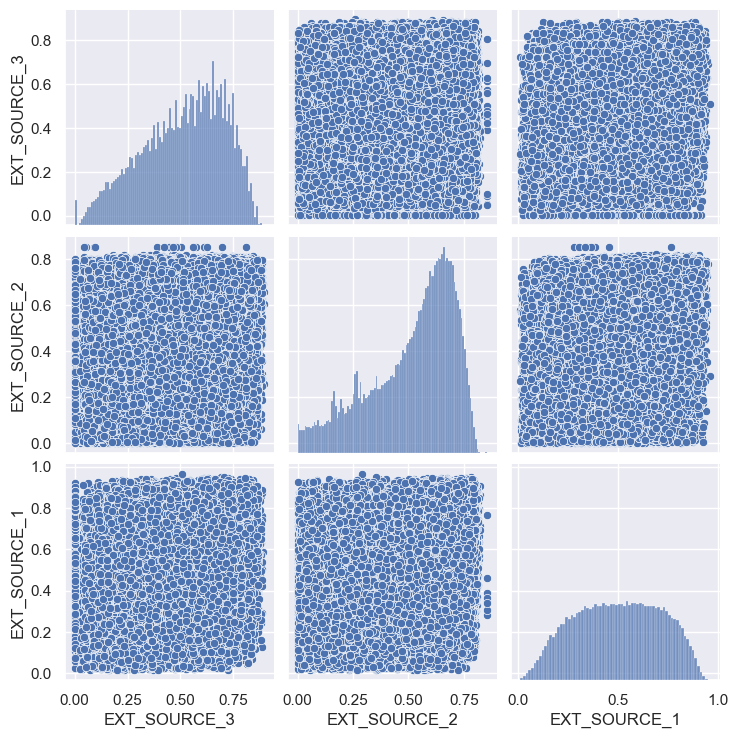

In [53]:
ext_cols = [
    "EXT_SOURCE_3",
    "EXT_SOURCE_2",
    "EXT_SOURCE_1",
]

sns.pairplot(train_df[ext_cols])
plt.show()


Since we have multiple columns which could make our data into some groups, it may be a good idead to use KNNImputer in order to fill in the missing values.

In [ ]:
# knn_imputer = KNNImputer(n_neighbors=5)
# impute_array = knn_imputer.fit_transform(train_df[ext_cols])

# sns.pairplot(pd.DataFrame(data=impute_array, columns=ext_cols))
# plt.show()

: 

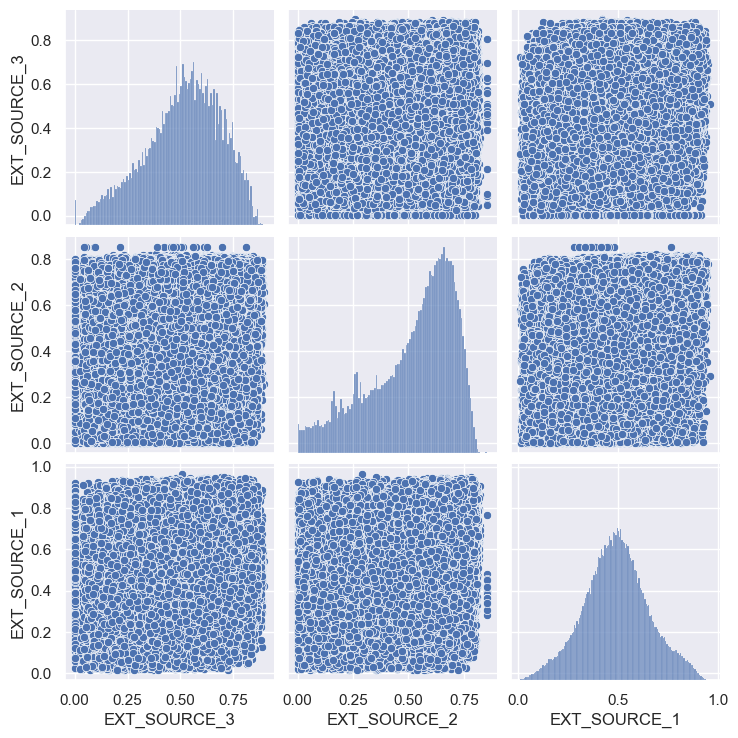

In [54]:
train_df, knn_imputer = micro.impute_na_cols(train_df, ext_cols)

test_df.loc[:, ext_cols] = knn_imputer.transform(test_df[ext_cols])


In order to fill the NaN values in `DAYS_EMPLOYED` columns we try to see if there is any relationship with other columns. one thought is that the NaN values might be because of that the applicant is unemployed let's test this hypothesis by analyzing the `NAME_INCOME_TYPE` column.

In [55]:
train_df[(train_df["DAYS_EMPLOYED"].isna())]["NAME_INCOME_TYPE"].value_counts()

NAME_INCOME_TYPE
Pensioner     55352
Unemployed       22
Name: count, dtype: int64

So wiht hugh certainty we can say that those who has NaN value in their `DAYS_EMPLOYED` columns could be a 'pensioner'. let's fill the values of this column with -1 which could indicated a non-positive value for the working days.

In [56]:
na_idx = train_df[(train_df["DAYS_EMPLOYED"].isna())].index
train_df.loc[na_idx, "DAYS_EMPLOYED"] = 1


## 3.3 Correlation

Since our data has values with different data types We start by grouping the columns that have numerical type with each other.

For numerical Values we need to find the values that has high correlation with each other so that we could reduce the size of the data. So we can find the name of the columns which has high correlation with each other as below and save to a DataFrame:

In [57]:
micro.compute_entire_correlation(df=train_df, threshold=0.7)

Numerical columns are: 
 ['CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE', 'DAYS_LAST_PHONE_CHANGE', 'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13', '

Based on the above Table we can deduce some results about our dataset and we might be able to reduce the size.

Description of the variables:
- `CNT_CHILDREN`: How many children does client have
- `CNT_FAM_MEMBERS`: How many family members does client have
- `REGION_RATING_CLIENT`: Our rating of the region where client lives (1,2,3)
- `REGION_RATING_CLIENT_W_CITY`: Our rating of the region where client lives with taking city into account (1,2,3)
- `OBS_30_CNT_SOCIAL_CIRCLE`: How many observation of client's social surroundings with observable 30 DPD (days past due) default
- `OBS_60_CNT_SOCIAL_CIRCLE`: How many observation of client's social surroundings with observable 60 DPD (days past due) default
- `DEF_30_CNT_SOCIAL_CIRCLE`: How many observation of client's social surroundings defaulted on 30 DPD (days past due) 
- `DEF_60_CNT_SOCIAL_CIRCLE` How many observation of client's social surroundings defaulted on 60 DPD (days past due) 

Analyzing the output of the correlation table:
- It is obvious that `CNT_CHILDREN` is strictly related to `CNT_FAM_MEMBERS`
- `AMT_CREDIT`, `AMT_AANUITY` and `AMT_GOODS_PRICE` are highly related which is also obvious since the credit that a person is searching for is mostly related to the price of the good that they are trying to buy.


Let's see the relationship between columns in a diagram:

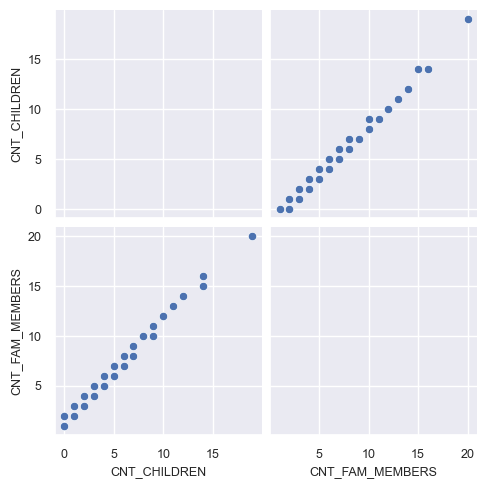

Correlation between 2 variables: 
                  CNT_CHILDREN  CNT_FAM_MEMBERS
CNT_CHILDREN         1.000000         0.879161
CNT_FAM_MEMBERS      0.879161         1.000000


In [58]:
micro.compute_corr_hist_plot(train_df, ["CNT_CHILDREN", "CNT_FAM_MEMBERS"])

Total Family members is always a function of the number of children and will have a high correlation, we will try and subtract the number of children from Family Members and name it "CNT_OTHER_FAM_MEMEBRS" This way we have erased the link between two variables.

In [59]:
train_df["CNT_OTHER_FAM_MEMBERS"] = (
    train_df["CNT_FAM_MEMBERS"] - train_df["CNT_CHILDREN"]
)

test_df["CNT_OTHER_FAM_MEMBERS"] = test_df["CNT_FAM_MEMBERS"] - test_df["CNT_CHILDREN"]
print(train_df[["CNT_OTHER_FAM_MEMBERS", "CNT_CHILDREN"]].corr())

train_df = train_df.drop(columns=["CNT_FAM_MEMBERS"])
test_df = test_df.drop(columns=["CNT_FAM_MEMBERS"])


                       CNT_OTHER_FAM_MEMBERS  CNT_CHILDREN
CNT_OTHER_FAM_MEMBERS                1.00000       0.17803
CNT_CHILDREN                         0.17803       1.00000


The low computed correlation approves that our method have works, we have kept the important data and also removed the correlation ebtween two varianbles.

Next we take a look at Credit variables:

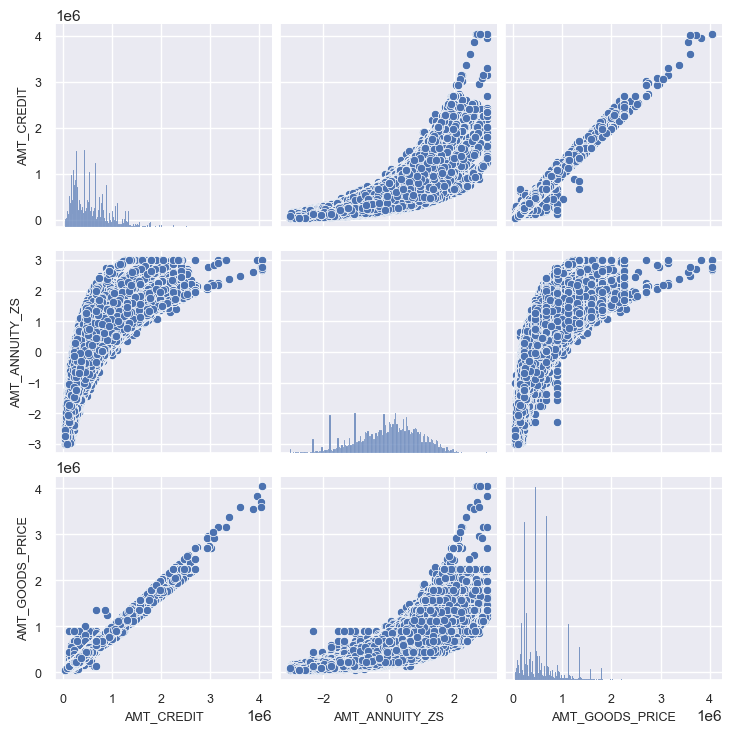

Correlation between 3 variables: 
                  AMT_CREDIT  AMT_ANNUITY_ZS  AMT_GOODS_PRICE
AMT_CREDIT         1.000000        0.764443         0.986968
AMT_ANNUITY_ZS     0.764443        1.000000         0.759044
AMT_GOODS_PRICE    0.986968        0.759044         1.000000


In [60]:
micro.compute_corr_hist_plot(
    train_df, ["AMT_CREDIT", "AMT_ANNUITY_ZS", "AMT_GOODS_PRICE"]
)


The correlation between `AMT_CREDIT` and `AMT_GOODS_PRICE_LOG` is very high (98.7%) We could replace thse two values by the division of `AMT_GOODS_PRICE_LOG/AMT_CREDIT`. This new variable could summarize that how much of the GOODs price the client has recieved the credit. Let's check our hypothesis:

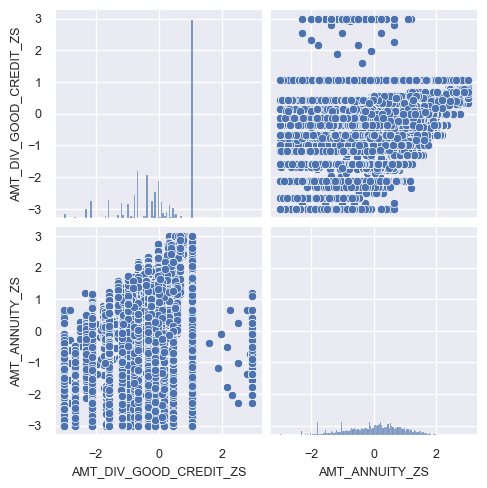

Correlation between 2 variables: 
                         AMT_DIV_GOOD_CREDIT_ZS  AMT_ANNUITY_ZS
AMT_DIV_GOOD_CREDIT_ZS                1.000000        0.000146
AMT_ANNUITY_ZS                        0.000146        1.000000


In [61]:
train_df["AMT_DIV_GOOD_CREDIT"] = train_df["AMT_GOODS_PRICE"] / train_df["AMT_CREDIT"]

train_df, standard_scaler = train_df.pipe(
    micro.compute_transform_zscore, col_name="AMT_DIV_GOOD_CREDIT"
)


test_df["AMT_DIV_GOOD_CREDIT"] = test_df["AMT_GOODS_PRICE"] / test_df["AMT_CREDIT"]

test_df["AMT_DIV_GOOD_CREDIT_ZS"] = test_df.pipe(
    micro.transform_test_data_zscore,
    col_name="AMT_DIV_GOOD_CREDIT",
    apply_log=True,
    std_scaler=standard_scaler,
)

train_df = train_df.drop(
    columns=[
        "AMT_GOODS_PRICE",
        "AMT_CREDIT",
        "AMT_DIV_GOOD_CREDIT",
        "AMT_DIV_GOOD_CREDIT_LOG",
    ]
)
test_df = test_df.drop(columns=["AMT_GOODS_PRICE", "AMT_CREDIT", "AMT_DIV_GOOD_CREDIT"])

micro.compute_corr_hist_plot(train_df, ["AMT_DIV_GOOD_CREDIT_ZS", "AMT_ANNUITY_ZS"])


We also double check the correlation with other credit amount varibales:

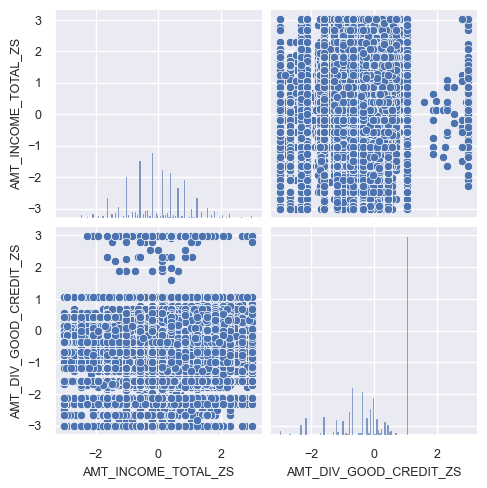

Correlation between 2 variables: 
                         AMT_INCOME_TOTAL_ZS  AMT_DIV_GOOD_CREDIT_ZS
AMT_INCOME_TOTAL_ZS                1.000000                0.042834
AMT_DIV_GOOD_CREDIT_ZS             0.042834                1.000000


In [62]:
micro.compute_corr_hist_plot(
    train_df, ["AMT_INCOME_TOTAL_ZS", "AMT_DIV_GOOD_CREDIT_ZS"]
)


We have been able to remove the high correlation between amount of credit variables.

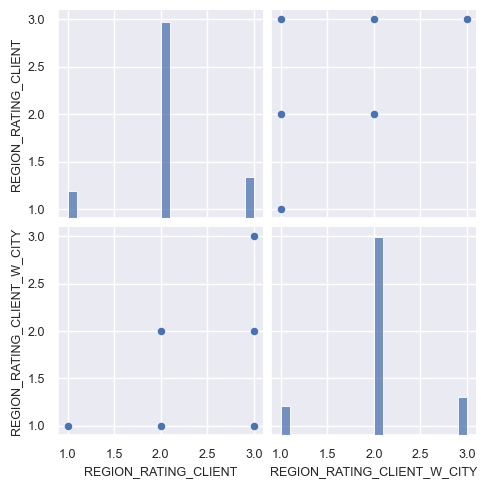

Correlation between 2 variables: 
                              REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY
REGION_RATING_CLIENT                     1.000000                     0.950842
REGION_RATING_CLIENT_W_CITY              0.950842                     1.000000


In [63]:
micro.compute_corr_hist_plot(
    train_df, ["REGION_RATING_CLIENT", "REGION_RATING_CLIENT_W_CITY"]
)


With a high value of 95% correlation, we might be able to merge these two variables. We define a varibale `EFF_CITY_ON_REGION` which values the effect of city on changing the region's score and we drop the `REGION_RATING_CLIENT_W_CITY` column.

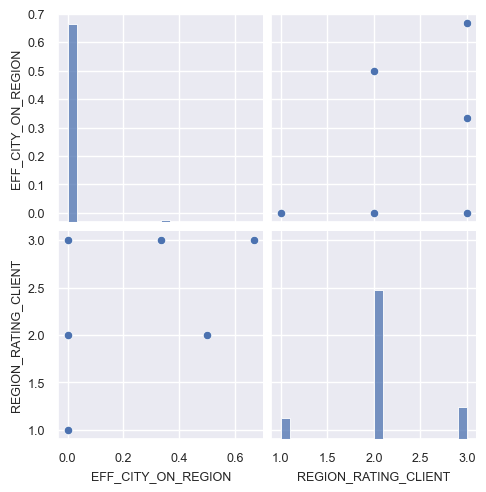

Correlation between 2 variables: 
                       EFF_CITY_ON_REGION  REGION_RATING_CLIENT
EFF_CITY_ON_REGION              1.000000              0.177289
REGION_RATING_CLIENT            0.177289              1.000000


In [64]:
# Effect of city on the region's score
train_df["EFF_CITY_ON_REGION"] = (
    1 - train_df["REGION_RATING_CLIENT_W_CITY"] / train_df["REGION_RATING_CLIENT"]
)

test_df["EFF_CITY_ON_REGION"] = (
    1 - test_df["REGION_RATING_CLIENT_W_CITY"] / test_df["REGION_RATING_CLIENT"]
)

micro.compute_corr_hist_plot(train_df, ["EFF_CITY_ON_REGION", "REGION_RATING_CLIENT"])


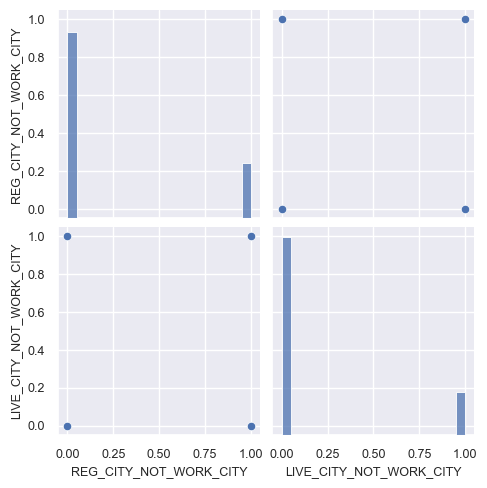

Correlation between 2 variables: 
                          REG_CITY_NOT_WORK_CITY  LIVE_CITY_NOT_WORK_CITY
REG_CITY_NOT_WORK_CITY                 1.000000                 0.825575
LIVE_CITY_NOT_WORK_CITY                0.825575                 1.000000


In [65]:
micro.compute_corr_hist_plot(
    train_df, ["REG_CITY_NOT_WORK_CITY", "LIVE_CITY_NOT_WORK_CITY"]
)


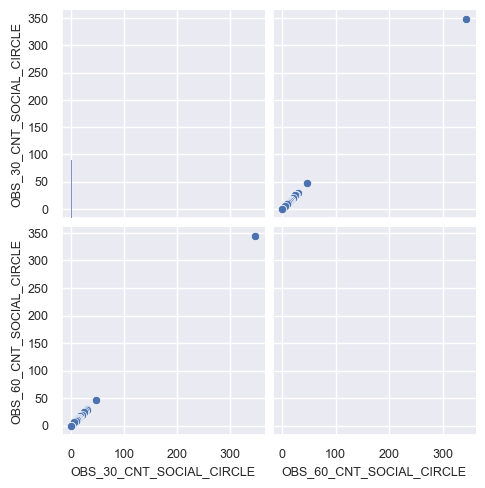

Correlation between 2 variables: 
                           OBS_30_CNT_SOCIAL_CIRCLE  OBS_60_CNT_SOCIAL_CIRCLE
OBS_30_CNT_SOCIAL_CIRCLE                   1.00000                   0.99849
OBS_60_CNT_SOCIAL_CIRCLE                   0.99849                   1.00000


In [66]:
micro.compute_corr_hist_plot(
    train_df, ["OBS_30_CNT_SOCIAL_CIRCLE", "OBS_60_CNT_SOCIAL_CIRCLE"]
)


As we can see the correlation between these two variables are very high as they could even one variable. So we take the Maximum between them and change the name to more general one like `OBS_CNT_SOCIAL_CIRCLE`

In [67]:
train_df["OBS_CNT_SOCIAL_CIRCLE"] = train_df[
    ["OBS_30_CNT_SOCIAL_CIRCLE", "OBS_60_CNT_SOCIAL_CIRCLE"]
].max(axis=1)

test_df["OBS_CNT_SOCIAL_CIRCLE"] = test_df[
    ["OBS_30_CNT_SOCIAL_CIRCLE", "OBS_60_CNT_SOCIAL_CIRCLE"]
].max(axis=1)

drop_cols = ["OBS_30_CNT_SOCIAL_CIRCLE", "OBS_60_CNT_SOCIAL_CIRCLE"]

train_df = train_df.drop(columns=drop_cols)
test_df = test_df.drop(columns=drop_cols)


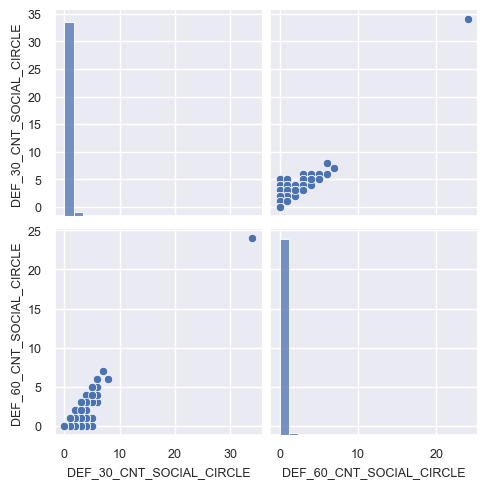

Correlation between 2 variables: 
                           DEF_30_CNT_SOCIAL_CIRCLE  DEF_60_CNT_SOCIAL_CIRCLE
DEF_30_CNT_SOCIAL_CIRCLE                  1.000000                  0.860517
DEF_60_CNT_SOCIAL_CIRCLE                  0.860517                  1.000000


In [68]:
micro.compute_corr_hist_plot(
    train_df, ["DEF_30_CNT_SOCIAL_CIRCLE", "DEF_60_CNT_SOCIAL_CIRCLE"]
)


Correlation between two variables are 86% which is also considered high. The definition of both variables is the number of defaulted persons in the social circle, The only thing that is different between these two si the number DPD (Days Past Due). We could try and remove the shared values in 30 and 60 DPD and define a new variable which is the number of people with more than 30 DPD.

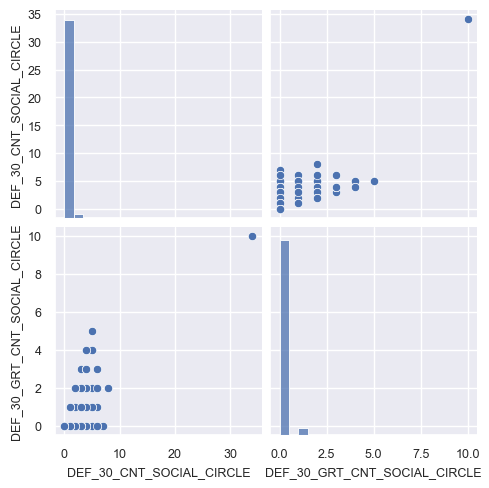

Correlation between 2 variables: 
                               DEF_30_CNT_SOCIAL_CIRCLE  \
DEF_30_CNT_SOCIAL_CIRCLE                      1.000000   
DEF_30_GRT_CNT_SOCIAL_CIRCLE                  0.590219   

                              DEF_30_GRT_CNT_SOCIAL_CIRCLE  
DEF_30_CNT_SOCIAL_CIRCLE                          0.590219  
DEF_30_GRT_CNT_SOCIAL_CIRCLE                      1.000000  


In [69]:
train_df["DEF_30_GRT_CNT_SOCIAL_CIRCLE"] = (
    train_df["DEF_30_CNT_SOCIAL_CIRCLE"] - train_df["DEF_60_CNT_SOCIAL_CIRCLE"]
)

test_df["DEF_30_GRT_CNT_SOCIAL_CIRCLE"] = (
    test_df["DEF_30_CNT_SOCIAL_CIRCLE"] - test_df["DEF_60_CNT_SOCIAL_CIRCLE"]
)

micro.compute_corr_hist_plot(
    train_df, ["DEF_30_CNT_SOCIAL_CIRCLE", "DEF_30_GRT_CNT_SOCIAL_CIRCLE"]
)


train_df = train_df.drop(columns=["DEF_60_CNT_SOCIAL_CIRCLE"])
test_df = test_df.drop(columns=["DEF_60_CNT_SOCIAL_CIRCLE"])


We were able to decrease the correlation value to about 60% with this approach.

Let's explore the 3 columns of external sources:
- `EXT_SOURCE_1` = Normalized score from external data source
- `EXT_SOURCE_2` = Normalized score from external data source
- `EXT_SOURCE_3` = Normalized score from external data source


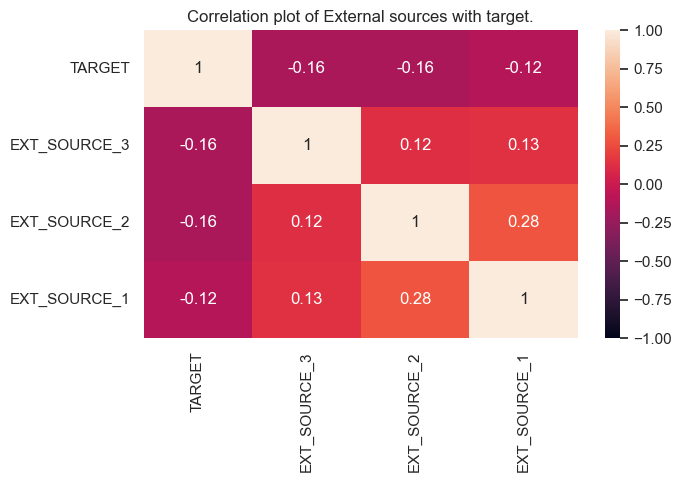

In [70]:
corr_df = train_df[
    [
        "TARGET",
        "EXT_SOURCE_3",
        "EXT_SOURCE_2",
        "EXT_SOURCE_1",
    ]
].corr()
fig = sns.heatmap(corr_df, vmin=-1.0, vmax=1.0, annot=True)
fig.set_title("Correlation plot of External sources with target.")
plt.show()


Let's see if we can handle these three columns using PCA to decrease the order.

In [72]:
ext_cols = [
    "EXT_SOURCE_3",
    "EXT_SOURCE_2",
    "EXT_SOURCE_1",
]

pca_trans = PCA(n_components=3)
pca_vals = pca_trans.fit_transform(train_df[ext_cols].values)

print(pca_vals)


[[ 0.54415697  0.18859823 -0.1961324 ]
 [-0.03521412 -0.04708844 -0.22164913]
 [-0.1193366  -0.17875961 -0.0581736 ]
 ...
 [-0.01037306  0.29271882  0.25028133]
 [-0.06457719 -0.1342535  -0.01743977]
 [-0.09595189  0.46110497  0.17746846]]


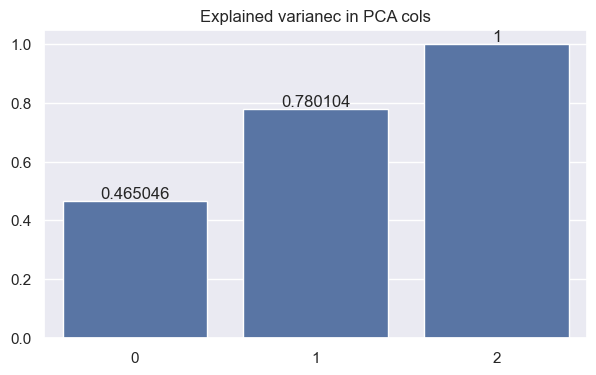

In [73]:
g = sns.barplot(np.cumsum(pca_trans.explained_variance_ratio_))
g.set_title("Explained varianec in PCA cols")

# SHow the values on chart
for x in g.containers:
    g.bar_label(
        x,
    )
plt.show()


In [80]:
train_df[["EXT_SOURCE_PCA_1", "EXT_SOURCE_PCA_2"]] = pca_vals[:, :2]

test_df[["EXT_SOURCE_PCA_1", "EXT_SOURCE_PCA_2"]] = pca_trans.transform(
    test_df[ext_cols]
)[:, :2]


It seems that they don't have much correlation with each other and also they could contribute into determining the 'TARGET' so we keep them as they are.

At the end we will drop the unneeded columns:

In [ ]:
no_need_cols = [
    "CNT_FAM_MEMBERS",
    "AMT_INCOME_TOTAL",
    "DEF_60_CNT_SOCIAL_CIRCLE",
    "OBS_30_CNT_SOCIAL_CIRCLE",
    "OBS_60_CNT_SOCIAL_CIRCLE",
    "REGION_RATING_CLIENT_W_CITY",
    "AMT_CREDIT",
    "AMT_GOODS_PRICE",
]

train_df = train_df.drop(columns=no_need_cols)